In [1]:
import yfinance as yf

df = yf.download('SPY').reset_index()

C:\Users\danny\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\danny\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\danny\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


[*********************100%***********************]  1 of 1 completed


## Features and Target

In [2]:
# Feature deriving

# Distance from the moving averages
for m in [10, 20, 30, 50, 100]:
    df[f'feat_dist_from_ma_{m}'] = df['Close']/df['Close'].rolling(m).mean()-1
    
# Distance from n day max/min
for m in [3, 5, 10, 15, 20, 30, 50, 100]:
    df[f'feat_dist_from_max_{m}'] = df['Close']/df['High'].rolling(m).max()-1
    df[f'feat_dist_from_min_{m}'] = df['Close']/df['Low'].rolling(m).min()-1
    
# Price distance
for m in [1, 2, 3, 4, 5, 10, 15, 20, 30, 50, 100]:
    df[f'feat_price_dist_{m}'] = df['Close']/df['Close'].shift(m)-1

In [3]:
# Target = if the price above the 20 ma in 5 days time
df['target_ma'] = df['Close'].rolling(20).mean()
df['price_above_ma'] = df['Close'] > df['target_ma']
df['target'] = df['price_above_ma'].astype(int).shift(-5)

## Train/Valid/Test Split

In [4]:
df = df.dropna()

feat_cols = [col for col in df.columns if 'feat' in col]
train_until = '2018-01-01'
valid_until = '2019-01-01'

train_filter = df['Date'] < train_until
valid_filter = (df['Date'] >= train_until) & (df['Date'] < valid_until)
test_filter = df['Date'] >= valid_until

x_train = df[train_filter][feat_cols]
y_train = df[train_filter]['target']

x_valid = df[valid_filter][feat_cols]
y_valid = df[valid_filter]['target']

x_test = df[test_filter][feat_cols]
y_test = df[test_filter]['target']

## Train the XGBoost Classifier

In [5]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score

params = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss',
    'random_state': 42,
    'learning_rate': 0.05,
    'nthread': -1,
    'max_depth': 5,
}

clf = xgb.XGBClassifier(**params)

clf.fit(
    x_train, 
    y_train, 
    eval_set=[(x_train, y_train), (x_valid, y_valid)], 
    verbose=False, 
    early_stopping_rounds=5,
)

# Predictions on training and test sets
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

# Calculate accuracy and precision scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

print('')
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Training Precision: {train_precision:.2f}')
print('')
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Precision: {test_precision:.2f}')

C:\Users\danny\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



Training Accuracy: 0.80
Training Precision: 0.81

Test Accuracy: 0.77
Test Precision: 0.80


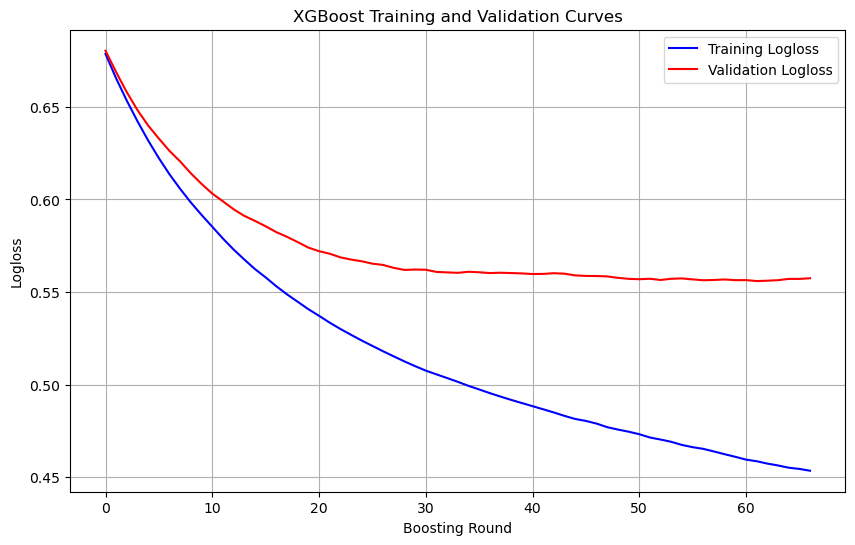

In [6]:
import matplotlib.pyplot as plt

results = clf.evals_result()

train_logloss = results['validation_0']['logloss']
valid_logloss = results['validation_1']['logloss']

plt.figure(figsize=(10, 6))
plt.plot(train_logloss, label='Training Logloss', color='blue')
plt.plot(valid_logloss, label='Validation Logloss', color='red')
plt.xlabel('Boosting Round')
plt.ylabel('Logloss')
plt.title('XGBoost Training and Validation Curves')
plt.legend()
plt.grid(True)
plt.show()

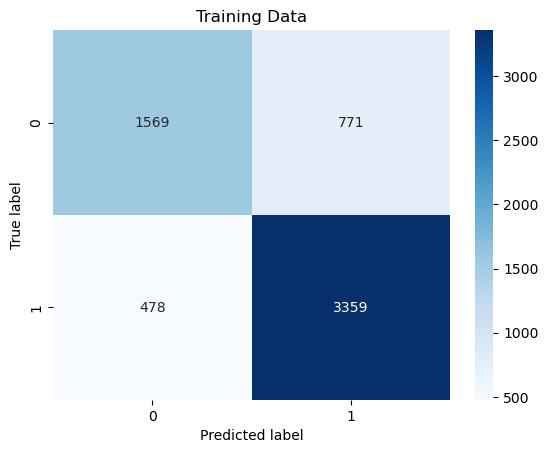

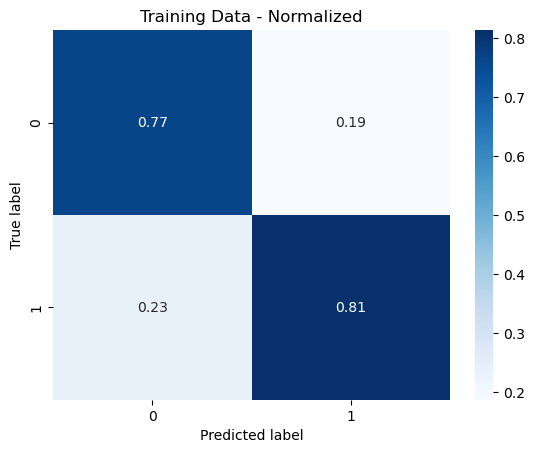

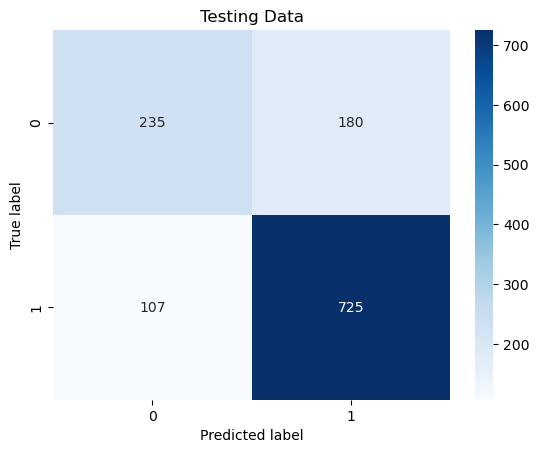

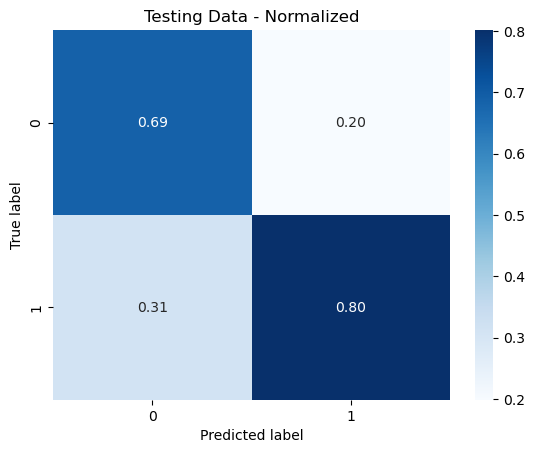

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title, normalize):

    if normalize:
        cm = confusion_matrix(y_true, y_pred, normalize='pred')
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    else:
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return
    
plot_confusion_matrix(y_train, y_train_pred, title='Training Data', normalize=False)
plot_confusion_matrix(y_train, y_train_pred, title='Training Data - Normalized', normalize=True)

plot_confusion_matrix(y_test, y_test_pred, title='Testing Data', normalize=False)
plot_confusion_matrix(y_test, y_test_pred, title='Testing Data - Normalized', normalize=True)

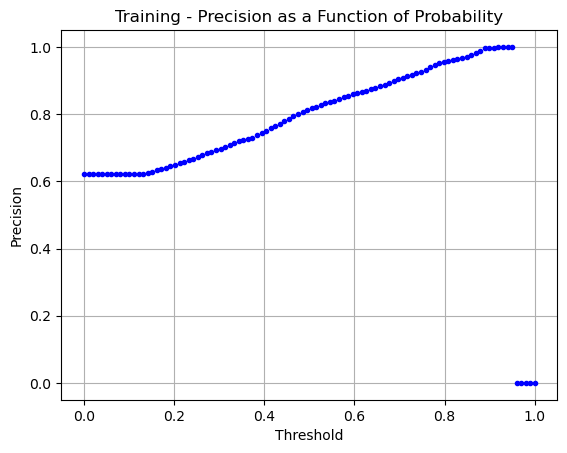

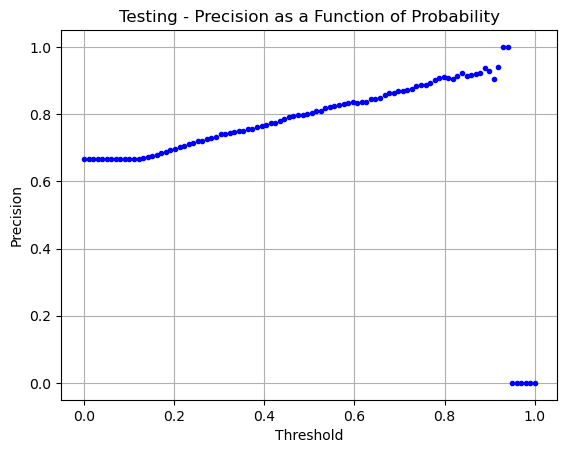

In [8]:
import numpy as np

def get_precision_curve(clf, x, y, title):

    y_scores = clf.predict_proba(x)[:, 1]

    thresholds = np.linspace(0, 1, 100)
    precision = []

    for t in thresholds:
        y_pred_threshold = (y_scores >= t).astype(int)
        precision.append(precision_score(y, y_pred_threshold, zero_division=0))

    plt.plot(thresholds, precision, 'b.')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title(title)
    plt.grid(True)
    plt.show()
    
    return

get_precision_curve(clf, x_train, y_train, 'Training - Precision as a Function of Probability')
get_precision_curve(clf, x_test, y_test, 'Testing - Precision as a Function of Probability')

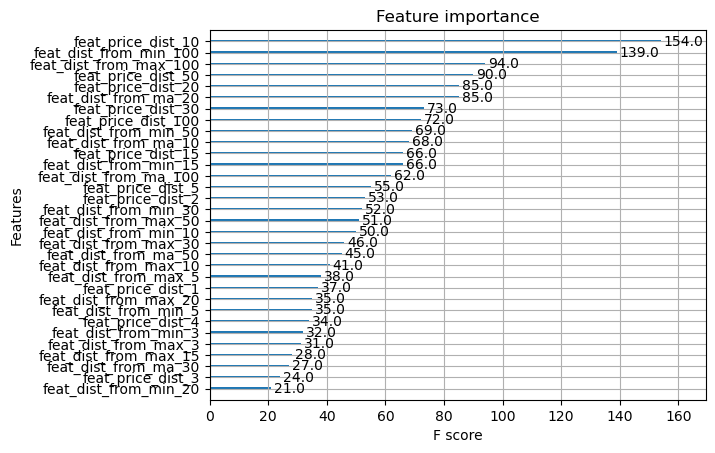

In [9]:
xgb.plot_importance(clf, importance_type='weight')
plt.show()

## Remove Correlated Features and Refit

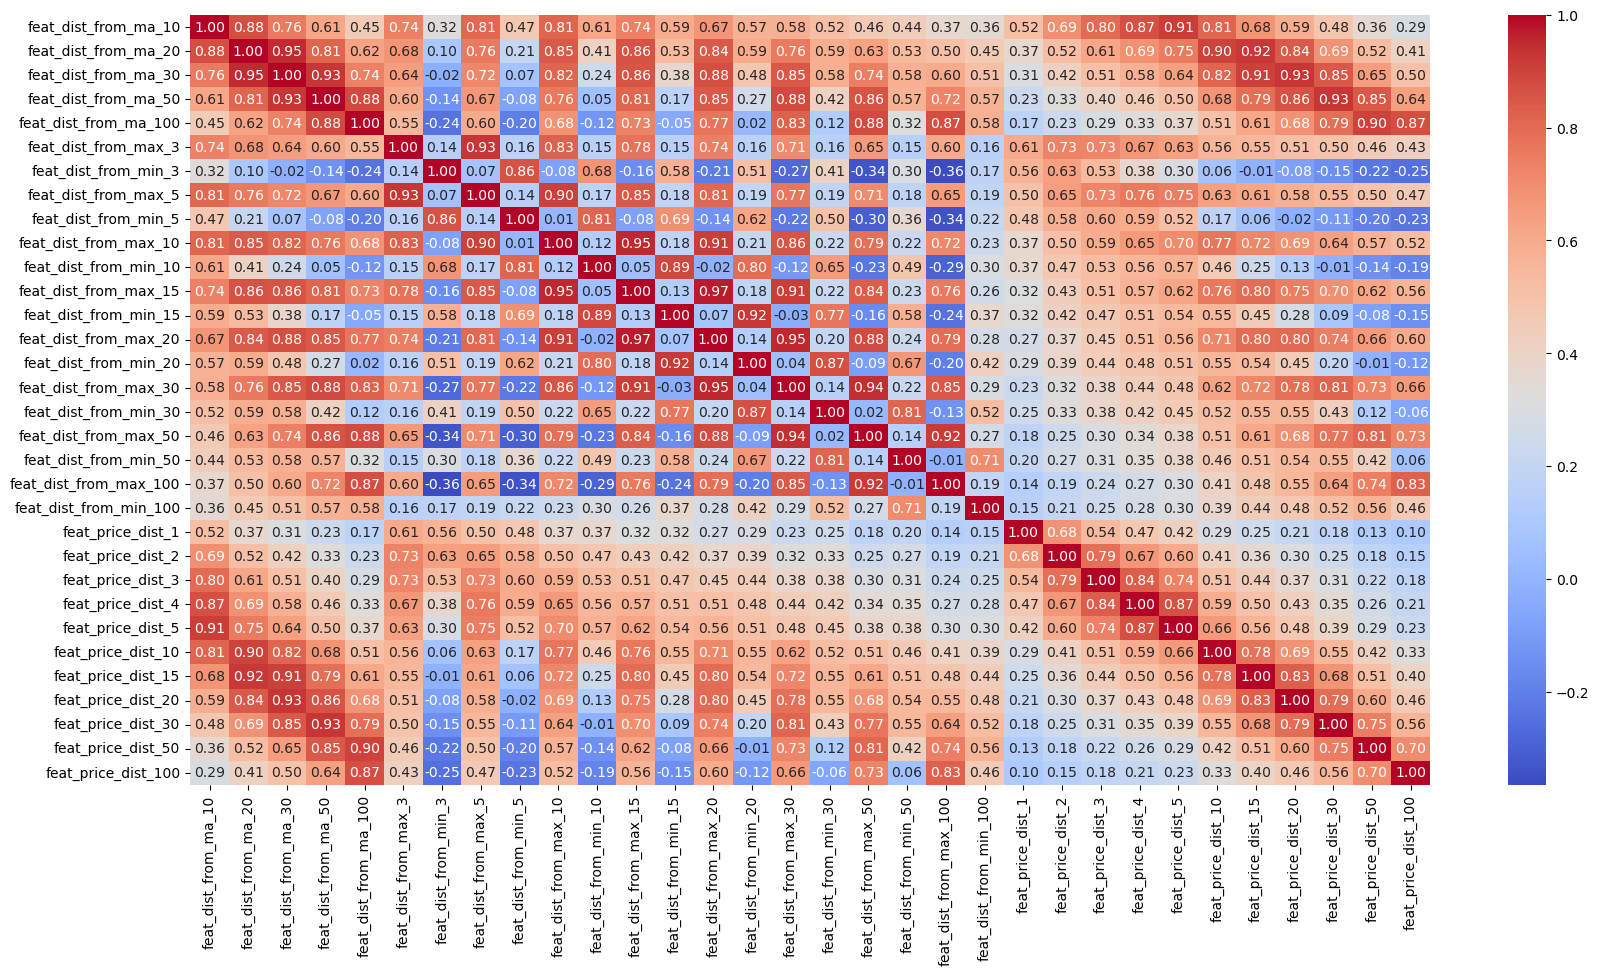

In [10]:
import seaborn as sns

corr_matrix = df[df['Date'] < train_until][feat_cols].corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [11]:
mask = np.triu(np.ones_like(corr_matrix.abs(), dtype=bool))
tri_df = corr_matrix.mask(mask)

to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.85)]
to_drop

['feat_dist_from_ma_10',
 'feat_dist_from_ma_20',
 'feat_dist_from_ma_30',
 'feat_dist_from_ma_50',
 'feat_dist_from_ma_100',
 'feat_dist_from_max_3',
 'feat_dist_from_min_3',
 'feat_dist_from_max_5',
 'feat_dist_from_max_10',
 'feat_dist_from_min_10',
 'feat_dist_from_max_15',
 'feat_dist_from_min_15',
 'feat_dist_from_max_20',
 'feat_dist_from_min_20',
 'feat_dist_from_max_30',
 'feat_dist_from_max_50',
 'feat_price_dist_4']

In [12]:
reduced_feat_cols = [col for col in df.columns if 'feat' in col and col not in to_drop]

x_train_reduced = df[train_filter][reduced_feat_cols]
y_train_reduced = df[train_filter]['target']

x_valid_reduced = df[valid_filter][reduced_feat_cols]
y_valid_reduced = df[valid_filter]['target']

x_test_reduced = df[test_filter][reduced_feat_cols]
y_test_reduced = df[test_filter]['target']

print('Number of features before reduction', len(feat_cols))
print('Number of features after reduction', len(reduced_feat_cols))

Number of features before reduction 32
Number of features after reduction 15


In [13]:
clf_reduced = xgb.XGBClassifier(**params)

clf_reduced.fit(
    x_train_reduced, 
    y_train_reduced, 
    eval_set=[(x_train_reduced, y_train_reduced), (x_valid_reduced, y_valid_reduced)], 
    verbose=False, 
    early_stopping_rounds=5,
)

# Predictions on training and test sets
y_train_pred = clf_reduced.predict(x_train_reduced)
y_test_pred = clf_reduced.predict(x_test_reduced)

# Calculate accuracy and precision scores
train_accuracy = accuracy_score(y_train_reduced, y_train_pred)
test_accuracy = accuracy_score(y_test_reduced, y_test_pred)

train_precision = precision_score(y_train_reduced, y_train_pred)
test_precision = precision_score(y_test_reduced, y_test_pred)

print('')
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Training Precision: {train_precision:.2f}')
print('')
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Precision: {test_precision:.2f}')

C:\Users\danny\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



Training Accuracy: 0.79
Training Precision: 0.80

Test Accuracy: 0.76
Test Precision: 0.79


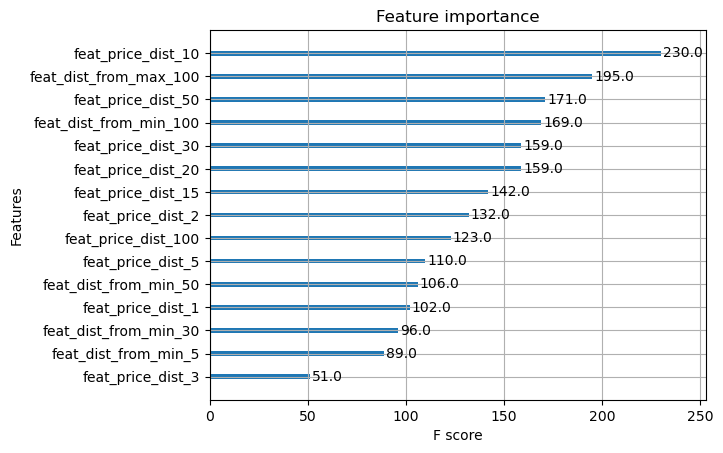

In [14]:
# Plot feature importances
xgb.plot_importance(clf_reduced, importance_type='weight')
plt.show()

## Visualise on the Chart

In [15]:
import plotly.graph_objects as go

df_test = df[df['Date'] >= valid_until].reset_index(drop=True)
df_test['pred_prob'] = clf_reduced.predict_proba(x_test_reduced)[:, 1]
df_test['pred'] = df_test['pred_prob'] > 0.5

fig = go.Figure()

fig.add_trace(
    go.Candlestick(
        x=df_test['Date'],
        open=df_test['Open'],
        high=df_test['High'],
        low=df_test['Low'],
        close=df_test['Close'],
        showlegend=False,
    )   
)

fig.add_trace(
    go.Line(x=df_test['Date'], y=df_test[f'target_ma'], showlegend=False)
)

df_pattern = (
    df_test[df_test['pred']]
    .groupby((~df_test['pred']).cumsum())
    ['Date']
    .agg(['first', 'last'])
)

for idx, row in df_pattern.iterrows():
    fig.add_vrect(
        x0=row['first'], 
        x1=row['last'],
        line_width=0,
        fillcolor='green',
        opacity=0.2,
    )

fig.update_layout(
    xaxis_rangeslider_visible=False,
    xaxis_title='Date',
    yaxis_title='Price ($)',
    title='Classified Results on SPY',
    width=1000,
    height=700,
)

fig.show()

C:\Users\danny\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## Use SHAP to Explain Decisions - Overall View

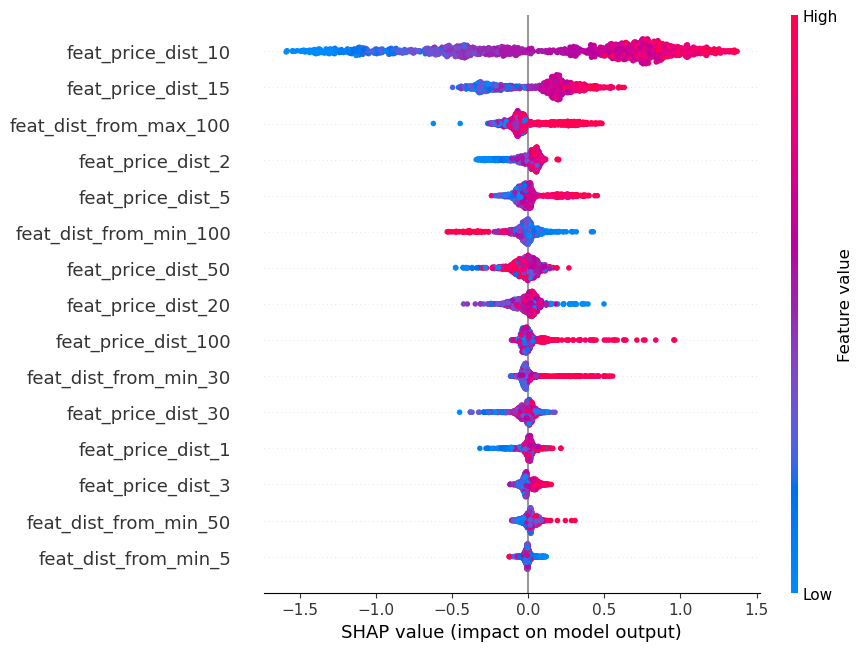

In [16]:
import shap

explainer = shap.TreeExplainer(clf_reduced)
explanation = explainer(x_test_reduced)
shap_values = explanation.values

shap.plots.beeswarm(explanation, max_display=len(reduced_feat_cols))

## Use Shap for Single Cases

In [17]:
import plotly.graph_objects as go

tmp_plot = df_test[
    (df_test['Date'] >= '2020-01-01')
    & (df_test['Date'] <= '2020-05-30')
]

fig = go.Figure()

fig.add_trace(
    go.Candlestick(
        x=tmp_plot['Date'],
        open=tmp_plot['Open'],
        high=tmp_plot['High'],
        low=tmp_plot['Low'],
        close=tmp_plot['Close'],
        showlegend=False,
    )   
)

fig.add_trace(
    go.Line(x=tmp_plot['Date'], y=tmp_plot[f'target_ma'], showlegend=False)
)

df_pattern = (
    tmp_plot[tmp_plot['pred']]
    .groupby((~tmp_plot['pred']).cumsum())
    ['Date']
    .agg(['first', 'last'])
)

for idx, row in df_pattern.iterrows():
    fig.add_vrect(
        x0=row['first'], 
        x1=row['last'],
        line_width=0,
        fillcolor='green',
        opacity=0.2,
    )

fig.update_layout(
    xaxis_rangeslider_visible=False,
    xaxis_title='Date',
    yaxis_title='Price ($)',
    title='Classified Results on SPY',
    width=1000,
    height=700,
)

fig.show()

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.



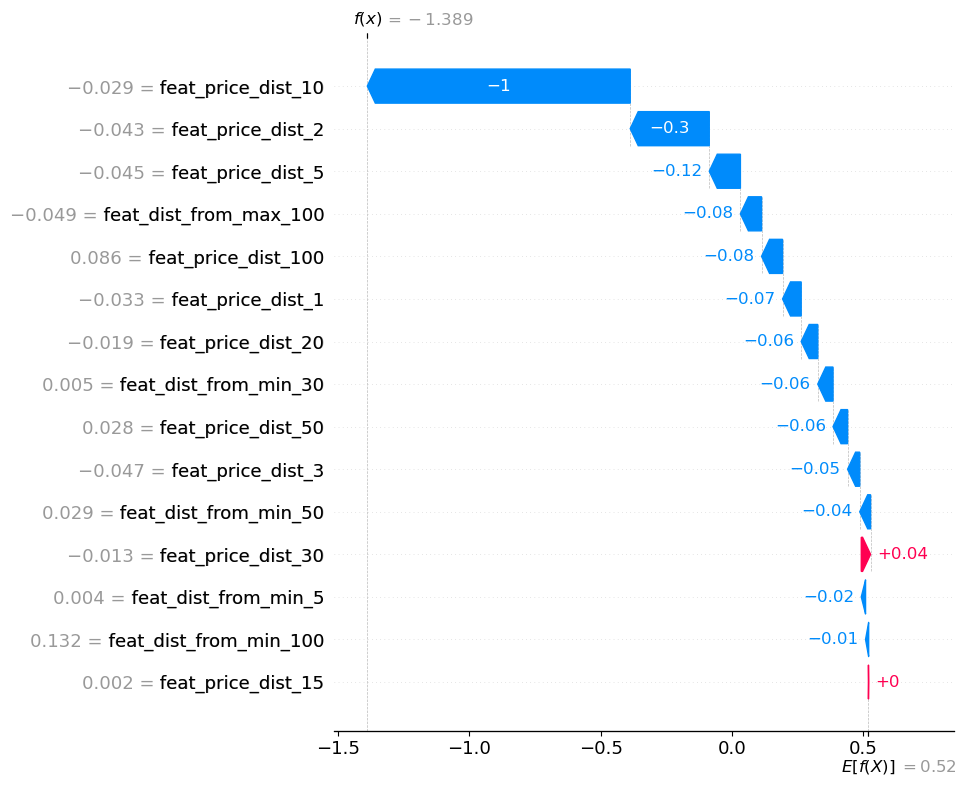

In [18]:
# 2020-02-24 is where the model first detects the COVID crash
idx = df_test[df_test['Date'] == '2020-02-24'].index[0]
shap.plots.waterfall(explanation[idx], max_display=len(reduced_feat_cols))

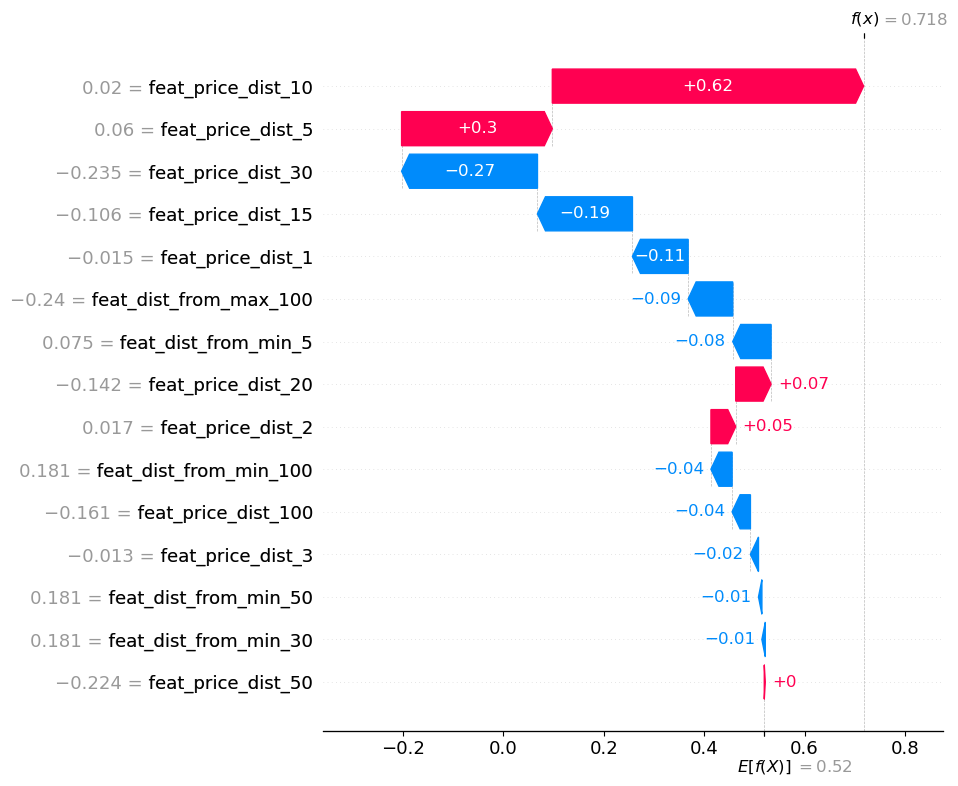

In [19]:
# 2020-03-31 is where the model first detects the COVID recovery
idx = df_test[df_test['Date'] == '2020-03-31'].index[0]
shap.plots.waterfall(explanation[idx], max_display=len(reduced_feat_cols))

In [20]:
import plotly.graph_objects as go

tmp_plot = df_test[
    (df_test['Date'] >= '2022-05-01')
    & (df_test['Date'] <= '2022-09-30')
]

fig = go.Figure()

fig.add_trace(
    go.Candlestick(
        x=tmp_plot['Date'],
        open=tmp_plot['Open'],
        high=tmp_plot['High'],
        low=tmp_plot['Low'],
        close=tmp_plot['Close'],
        showlegend=False,
    )   
)

fig.add_trace(
    go.Line(x=tmp_plot['Date'], y=tmp_plot[f'target_ma'], showlegend=False)
)

df_pattern = (
    tmp_plot[tmp_plot['pred']]
    .groupby((~tmp_plot['pred']).cumsum())
    ['Date']
    .agg(['first', 'last'])
)

for idx, row in df_pattern.iterrows():
    fig.add_vrect(
        x0=row['first'], 
        x1=row['last'],
        line_width=0,
        fillcolor='green',
        opacity=0.2,
    )

fig.update_layout(
    xaxis_rangeslider_visible=False,
    xaxis_title='Date',
    yaxis_title='Price ($)',
    title='Classified Results on SPY',
    width=1000,
    height=700,
)

fig.show()

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.



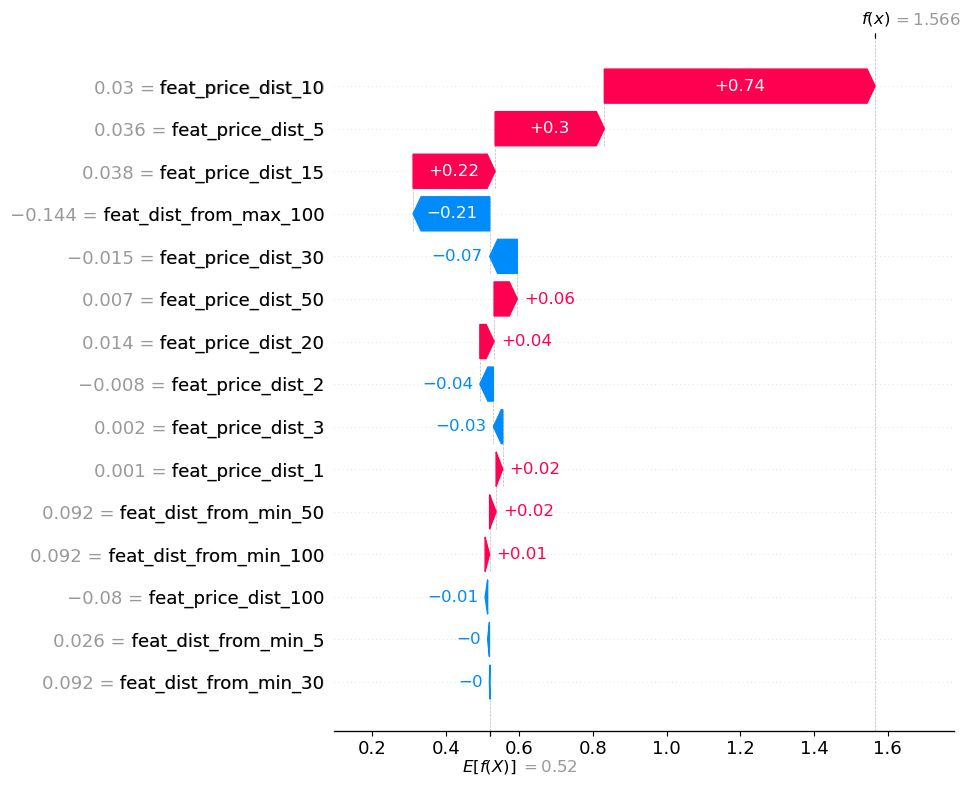

In [21]:
# 2022-07-25 is where the model detects a market rally in the 2022 bear market
idx = df_test[df_test['Date'] == '2022-07-25'].index[0]
shap.plots.waterfall(explanation[idx], max_display=len(reduced_feat_cols))

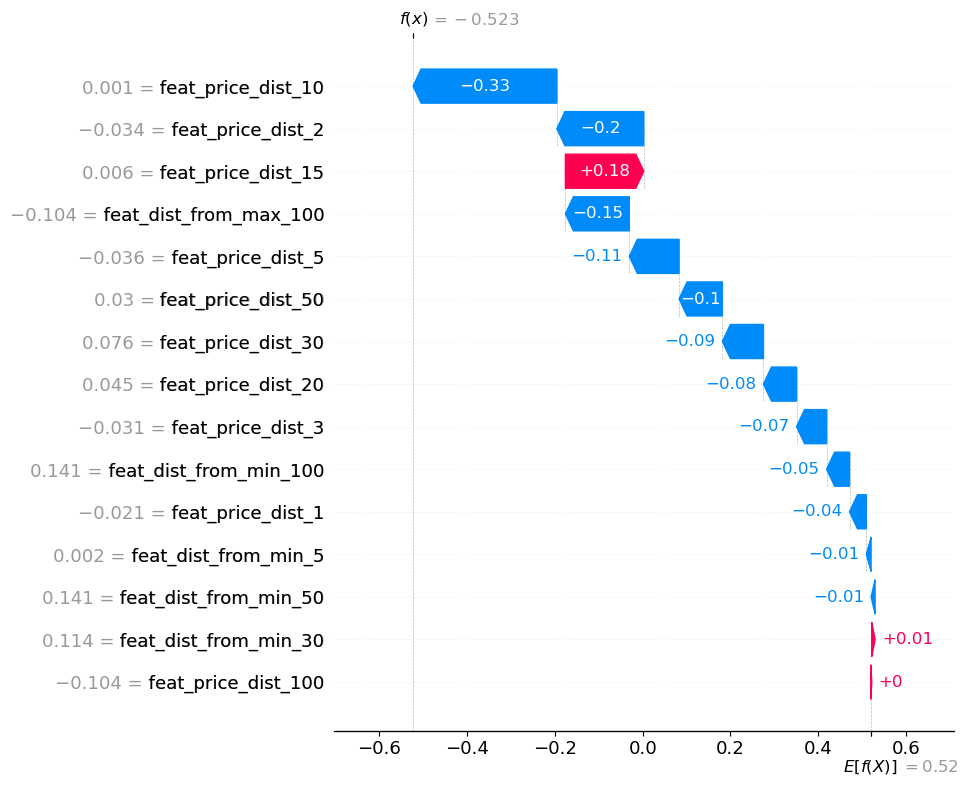

In [22]:
# 2022-08-22 is where the model detects the rally end
idx = df_test[df_test['Date'] == '2022-08-22'].index[0]
shap.plots.waterfall(explanation[idx], max_display=len(reduced_feat_cols))